# Milestone 1: Getting to know your data

### Group 11:  Chongfan Tai, Hungyi Wu, Xu Si

In the beginning you should get acquainted with the data sources and do some EDA. Sign up for the TMDb [API](https://www.themoviedb.org/documentation/api), and try to download the poster of your favorite movie from within your notebook. Compare the genre entries of IMDb and TMDb for this movie and see if they are the same. Think about and write down some questions that you would like to answer in the following weeks. Keep the storytelling aspect of your final report in mind and do some pen and paper sketches about the visualizations you would like to produce. Include photographs of those sketches in your notebook. 

Most of the time a data scientist spends on a project is spent on cleaning the data. We are lucky that the data we have is already pretty clean. The Python interface to the IMDb ftp files does a lot of the additional work of cleaning as well. However, you will notice that the genre list for each movie from both databases can have different lengths. This needs to be changed in order to train a model to predict the movie genre. It is up to you to think about possible ways to address this problem and to implement one of them. There is no absolute right answer here. It depends on your interests and which questions you have in mind for the project. 

Optionally, you could also scrape additional data sources, such as Wikipedia, to obtain plot summaries. That data may give you additional useful features for genre classification. 

To guide your decision process, provide at least one visualization of how often genres are mentioned together in pairs. Your visualization should clearly show if a horror romance is more likely to occur in the data than a drama romance.

The notebook to submit for this milestone needs to at least include:

- API code to access the genre and movie poster path of your favorite movie
- Genre for this movie listed by TMDb and IMDb
- A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
- Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them 
- Code to generate the movie genre pairs and a suitable visualization of the result
- Additional visualization sketches and EDA with a focus on movie genres
- A list of questions you could answer with this and related data. Get creative here!

The EDA questions do not necessarily have to tie into the modeling part later on. Think freely about things that might be interesting, like which actors are very specific to a genre? Are action movies more prone to producing sequels than romances? However, as you keep the focus on movie genres, think also about correlations you might discover that can help build features from the metadata for prediction. Is the length of a movie title correlated with genre?

In [296]:
import pickle
import seaborn as sns
import numpy as np
import httplib
import json
from skimage import io
from imdb import IMDb
import pandas as pd
from os import listdir
from os.path import isfile, join, expanduser
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser
from collections import Counter
from itertools import combinations
%matplotlib inline

## 1.API code to access the genre and movie poster path of your favorite movie

We **"Fantastic Beasts and Where to Find Them"** as our favorite movie!

- IMDb

In [230]:
#search by name 
ia = IMDb(accessSystem= 'http' )
search_movie = ia.search_movie('Fantastic Beasts and Where to Find Them')
search_movie

[<Movie id:3183660[http] title:_Fantastic Beasts and Where to Find Them (2016)_>,
 <Movie id:6677432[http] title:_"Fantastic Beasts and Where to Find Them (2016) (TV Episode)  - Season 1 | Episode 12  - The Dom Reviews" (2014)_>,
 <Movie id:4123430[http] title:_Fantastic Beasts and Where to Find Them 2 (2018)_>,
 <Movie id:4123432[http] title:_Fantastic Beasts and Where to Find Them 3 (2020)_>,
 <Movie id:6149054[http] title:_Fantastic Beasts and Where to Find Them 5 (2024)_>,
 <Movie id:6149052[http] title:_Fantastic Beasts and Where to Find Them 4 (2022)_>,
 <Movie id:4940424[http] title:_"Fantastic Beasts and Where to Find Them/Bleed for This/The Edge of Seventeen/Manchester by the Sea (2016) (TV Episode)  - Season 12 | Episode 10  - Made in Hollywood" (2005)_>,
 <Movie id:6709962[http] title:_"Fantastic Beasts & Where to Find Them (2017) (TV Episode)  - Season 6 | Episode 13  - Honest Trailers" (2012)_>,
 <Movie id:6241668[http] title:_"Cast of "Fantastic Beasts and Where to Find T

**The very first line in the searching result is what we want! Now, we get poster and genres by the id '3183660'.**

Fantastic Beasts and Where to Find Them
Genres from IMDb:  [u'Adventure', u'Family', u'Fantasy']


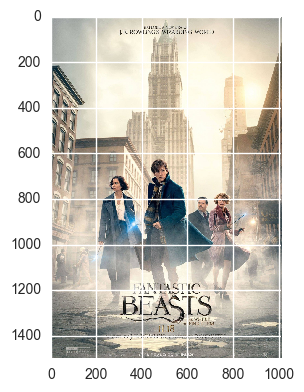

In [229]:
#IMDb
favorite_movie_imdb = ia.get_movie(3183660) 
print favorite_movie_imdb
print "Genres from IMDb: ", favorite_movie_imdb['genres']
io.imshow(io.imread(favorite_movie_imdb['full-size cover url']))
io.show()

- TMDb

In [ ]:
#a function for general request, e.g. discover,search,find
def tmdb_request(url):
    api_key = "&api_key=7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", url + api_key)
    res = conn.getresponse()
    data = res.read()
    j = json.loads(data)
    return j

#get tmdb info by imdb id
def tmdb_get_movie_by_imdb_id(imdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/find/tt"+str(imdb_id)+"?api_key="+api_key+"&external_source=imdb_id", 
                 "{}")
    data = json.loads(conn.getresponse().read().decode("utf-8"))
    tmdb_id = data['movie_results'][0]['id']
    return tmdb_get_movie_by_tmdb_id(tmdb_id)
 
#get tmdb info by tmdb id
def tmdb_get_movie_by_tmdb_id(tmdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/"+str(tmdb_id)+"?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

#get the full url of poster
def tmdb_get_poster_url(path):
    return "https://image.tmdb.org/t/p/w500" + path

**Interesting finding: ** We tried both ways to retrieve information from TMDb: either use *find by IMBd ID* or *find by TMDb ID*. It seems that the details acquired via the latter option is more up-to-date than using *find by IMBd ID*, since we see more number of votes using the former way. 

We later decide to acquire TMDb info first and then use the IMDb ID acquired through the attribute from TMDb info to acquire corresponding info from IMDb.

Genres:  [{u'id': 12, u'name': u'Adventure'}, {u'id': 28, u'name': u'Action'}, {u'id': 14, u'name': u'Fantasy'}]


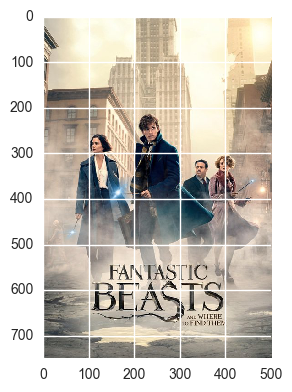

In [228]:
favorite_movie_tmdb = json.loads(tmdb_get_movie_by_imdb_id(3183660))
print 'Genres: ', favorite_movie_tmdb['genres']
url = tmdb_get_poster_url(favorite_movie_tmdb['poster_path'])
io.imshow(io.imread(url))
io.show()

## 2.Genre for this movie listed by TMDb and IMDb

In [225]:
print "Genres from IMDb: ", favorite_movie_imdb['genres']
print "Genres from TMDb: ", favorite_movie_tmdb['genres']

Genres from IMDb:  [u'Adventure', u'Family', u'Fantasy']
Genres from TMDb:  [{u'id': 12, u'name': u'Adventure'}, {u'id': 28, u'name': u'Action'}, {u'id': 14, u'name': u'Fantasy'}]


## 3.A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API

In [12]:
#get top 10 popular movies of 2016 using discover
popular_2016 = tmdb_request("/3/discover/movie?primary_release_year=2016&sort_by=popularity.desc")
print popular_2016.keys()
popular_2016_top_10 = popular_2016['results'][:10]

[u'total_results', u'total_pages', u'page', u'results']


In [13]:
for m in popular_2016_top_10:
    title = m['title']
    ID = m['id']
    genre_dict = json.loads(tmdb_get_movie_by_tmdb_id(ID))['genres'] #get details by ID and retrieve genres
    genre_list =  [str(ele['name']) for ele in genre_dict] #transrform into a nicer form
    print title, genre_list #print result

Sing ['Animation', 'Comedy', 'Drama', 'Family', 'Music']
Fantastic Beasts and Where to Find Them ['Adventure', 'Action', 'Fantasy']
Finding Dory ['Adventure', 'Animation', 'Comedy', 'Family']
Deadpool ['Action', 'Adventure', 'Comedy', 'Romance']
Rogue One: A Star Wars Story ['Action', 'Drama', 'Science Fiction', 'War']
Doctor Strange ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Arrival ['Drama', 'Science Fiction']
Captain America: Civil War ['Action', 'Science Fiction']
Underworld: Blood Wars ['Action', 'Horror']
Lion ['Drama']


## 4.Code to generate the movie genre pairs and a suitable visualization of the result

In [300]:
genre_list = []
genre_collapse_list = []
for e in tmdb_demo['genres'].values:
    l = [i['name'] for i in e]
    genre_collapse_list += l
    genre_list.append(l)

In [294]:
genre_category_list = dict(Counter(genre_collapse_list)).keys()
df2 = pd.DataFrame(0, columns = genre_category_list, index = genre_category_list)

for genre in genre_list:
    for pair in list(combinations(genre, 2)):
        df2.loc[pair[0], pair[1]] += 1
        df2.loc[pair[1], pair[0]] += 1

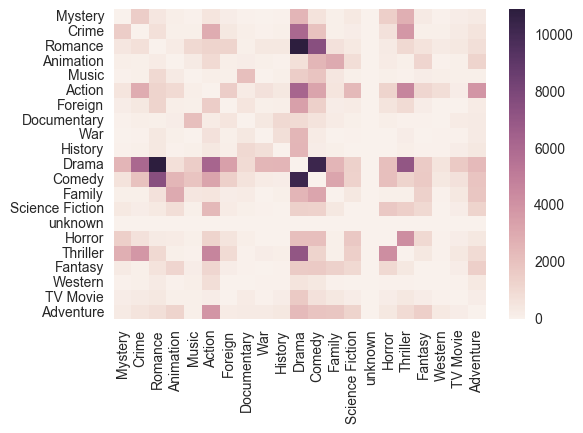

In [297]:
sns.heatmap(df2)

**Observation: The heatmap visualizes the counts of the genre pairs. Drama/Romance, Drama/Comedy, Drama/Thriller are the top three most common combinations. To better visualization, we draw the bar plots below. We can see the top five most common genres are all drama. 
**

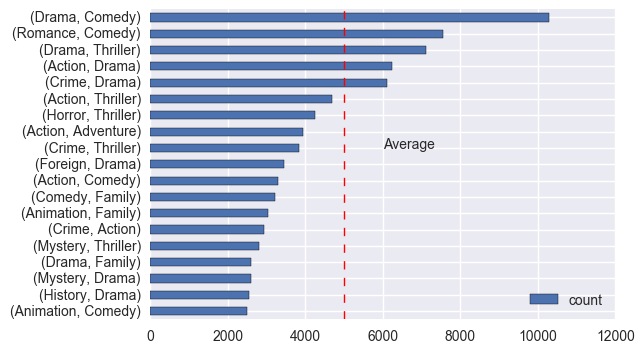

In [303]:
pair_list = list(combinations(genre_category_list, 2))
df3 = pd.DataFrame(columns = ["movie 1", "movie 2", "count"], index = pair_list)
for index, pair in enumerate(pair_list):
    df3.loc[pair, "movie 1"] = pair[0]
    df3.loc[pair, "movie 2"] = pair[1]
    df3.loc[pair, "count"] = df2.loc[pair[0], pair[1]]
    
df3.sort_values("count", ascending = True).iloc[-20:-1].plot(kind = "barh")
plt.axvline(x=5000, linestyle = "--", color = "r", linewidth = 1)
plt.annotate("Average", xy = (6000, 10))

## 5.A list of questions you could answer with this and related data. Get creative here!

- What combinations of genres are most common in production? What about the revenue? Does it change over time? 
- What genres or combinations of genres receive high ratings on IMDb and TMDb? Do the popularities change over time? 
- What genre receives highest earnings over the time? And what about in different periods?
- What genre receives highest IMDb scores over the time? And what about in different periods?
- What genre receives most reviews on IMDb?
- What genre receives cost the most in the past 10 years?
- What factors are useful to predict a movie’s genre? 
- Is genre statistically significant to predict the gross income?
- Do highly-rated directors tend to excel in certain type of movies? Who are the “masters” in directing each genre?
- Is movie genre an influencer to box office? 

## 6.Additional visualization sketches and EDA with a focus on movie genres

### Sketches

1.Who makes up a genre? 

We can visulize the proportion of movies, of the same genre, from U.S., China, India, etc. and sort them in descending order. Then it is easy to see whether a country is domiant in a specific genre. We may connect Romance with U.S. and Comedy with U.K., for example, to tell the correlation between genre and country.

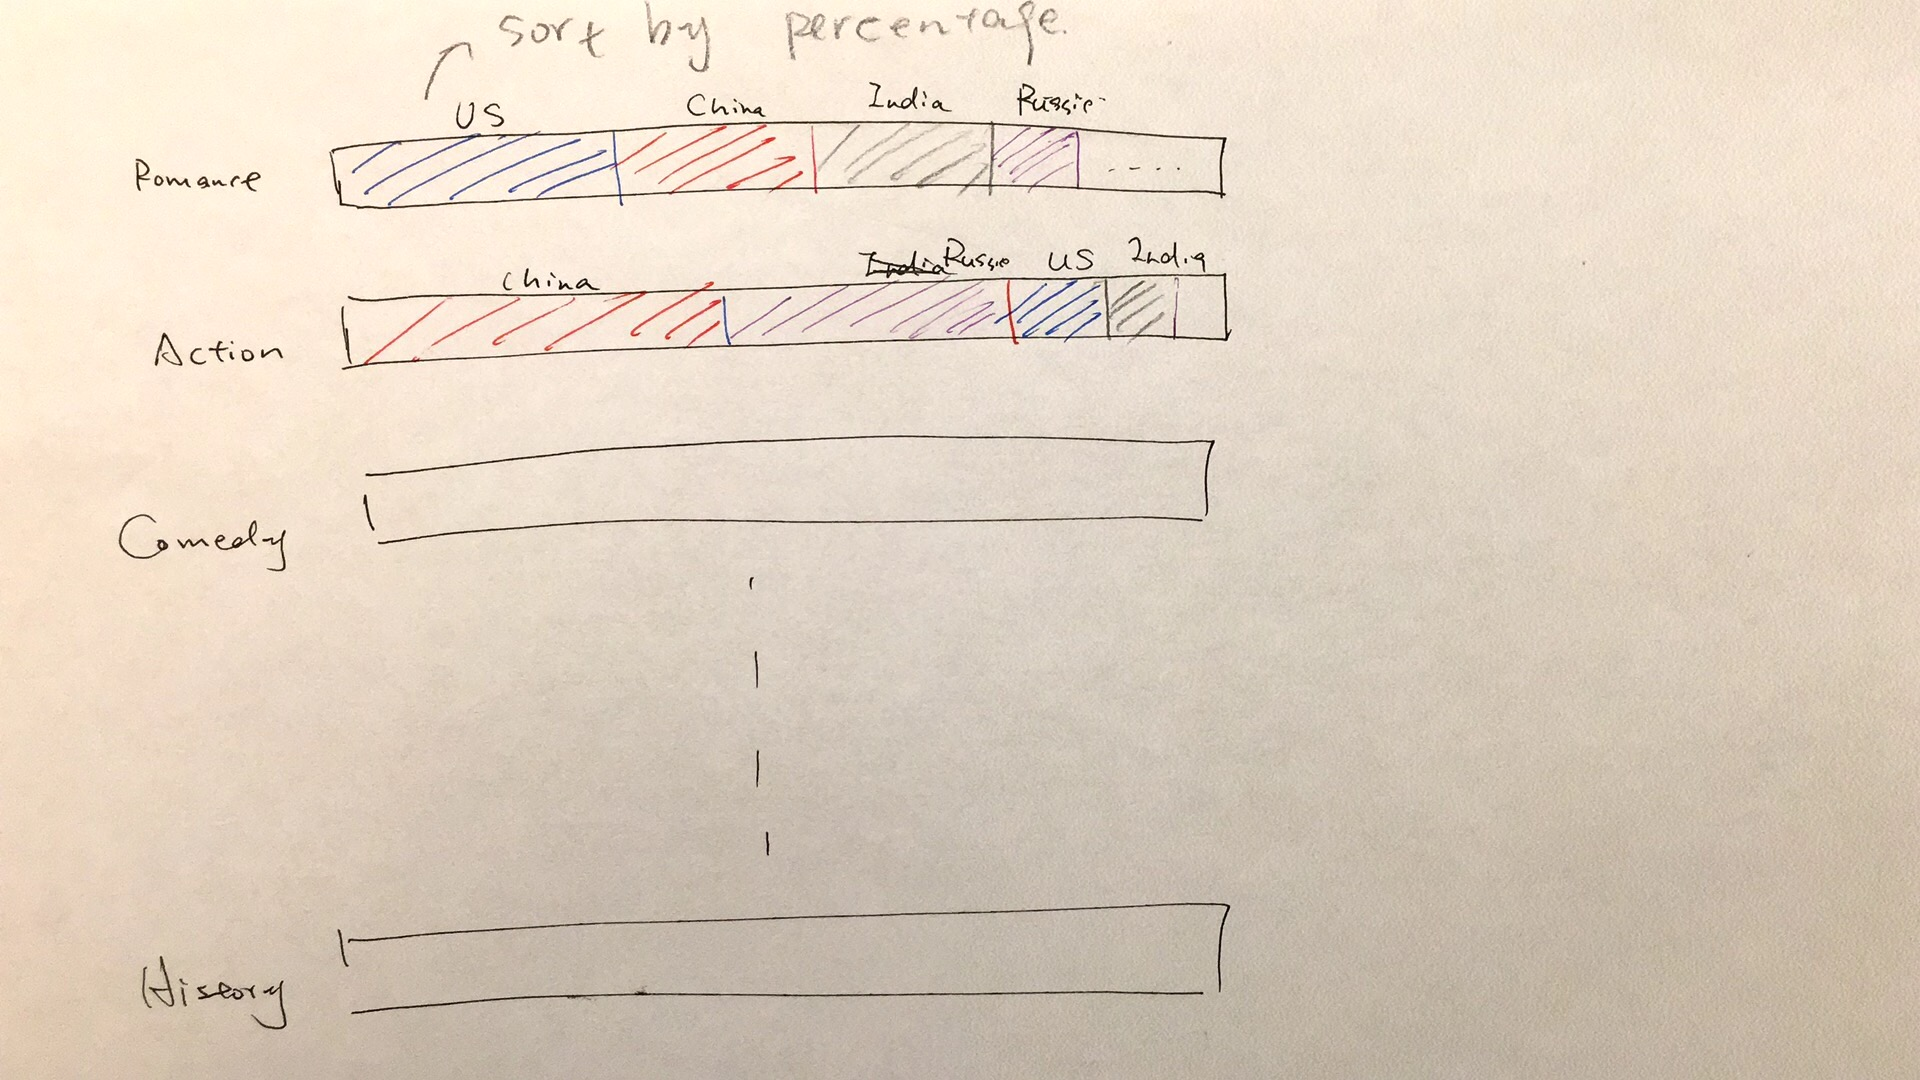

In [320]:
from IPython.display import Image
Image(filename='./sketches/1.jpg',width=1000)

2.Does year matters? 

In the linechart below, we can ask is genre associates with time? For instance, people may vote for action in the 2010s while may not like history movies. Genres can be times-related.

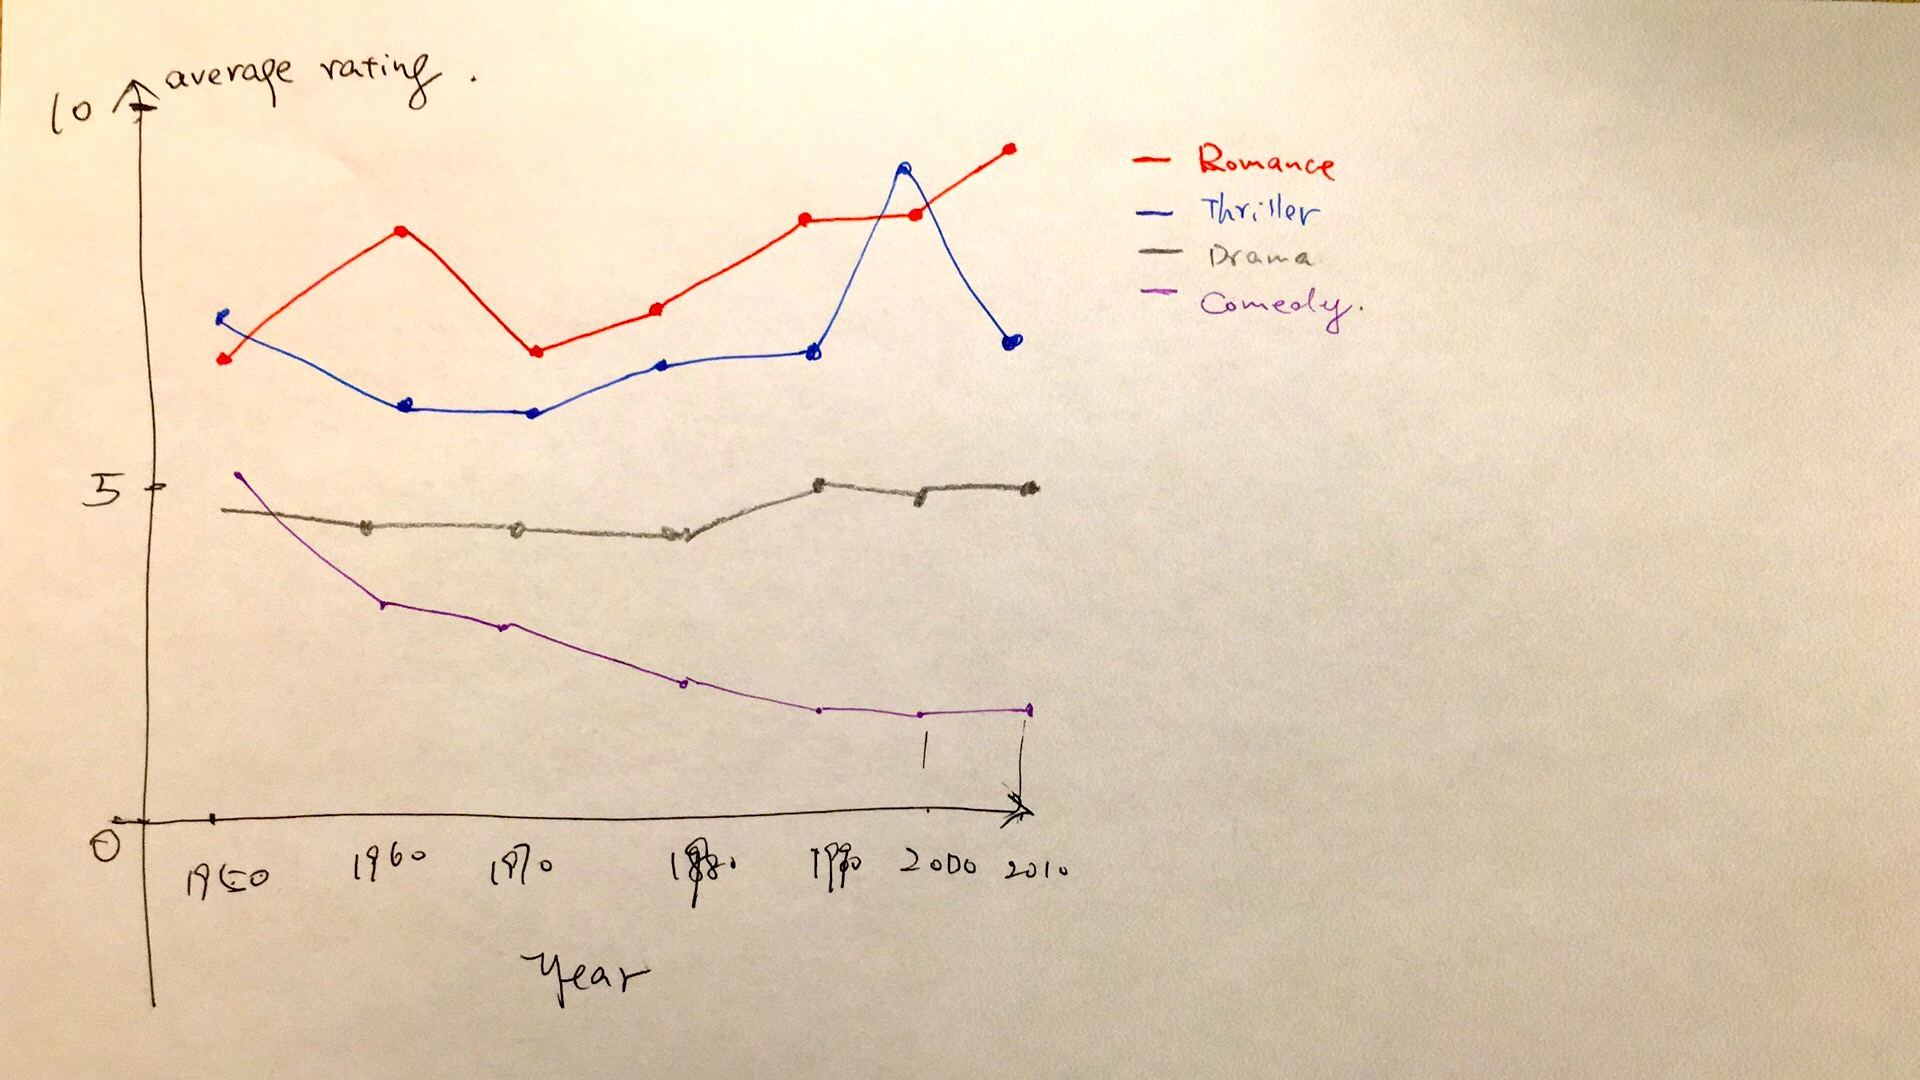

In [321]:
from IPython.display import Image
Image(filename='./sketches/2.jpg',width=1000)

3.Genre pairs! We make it in our EDA part following.

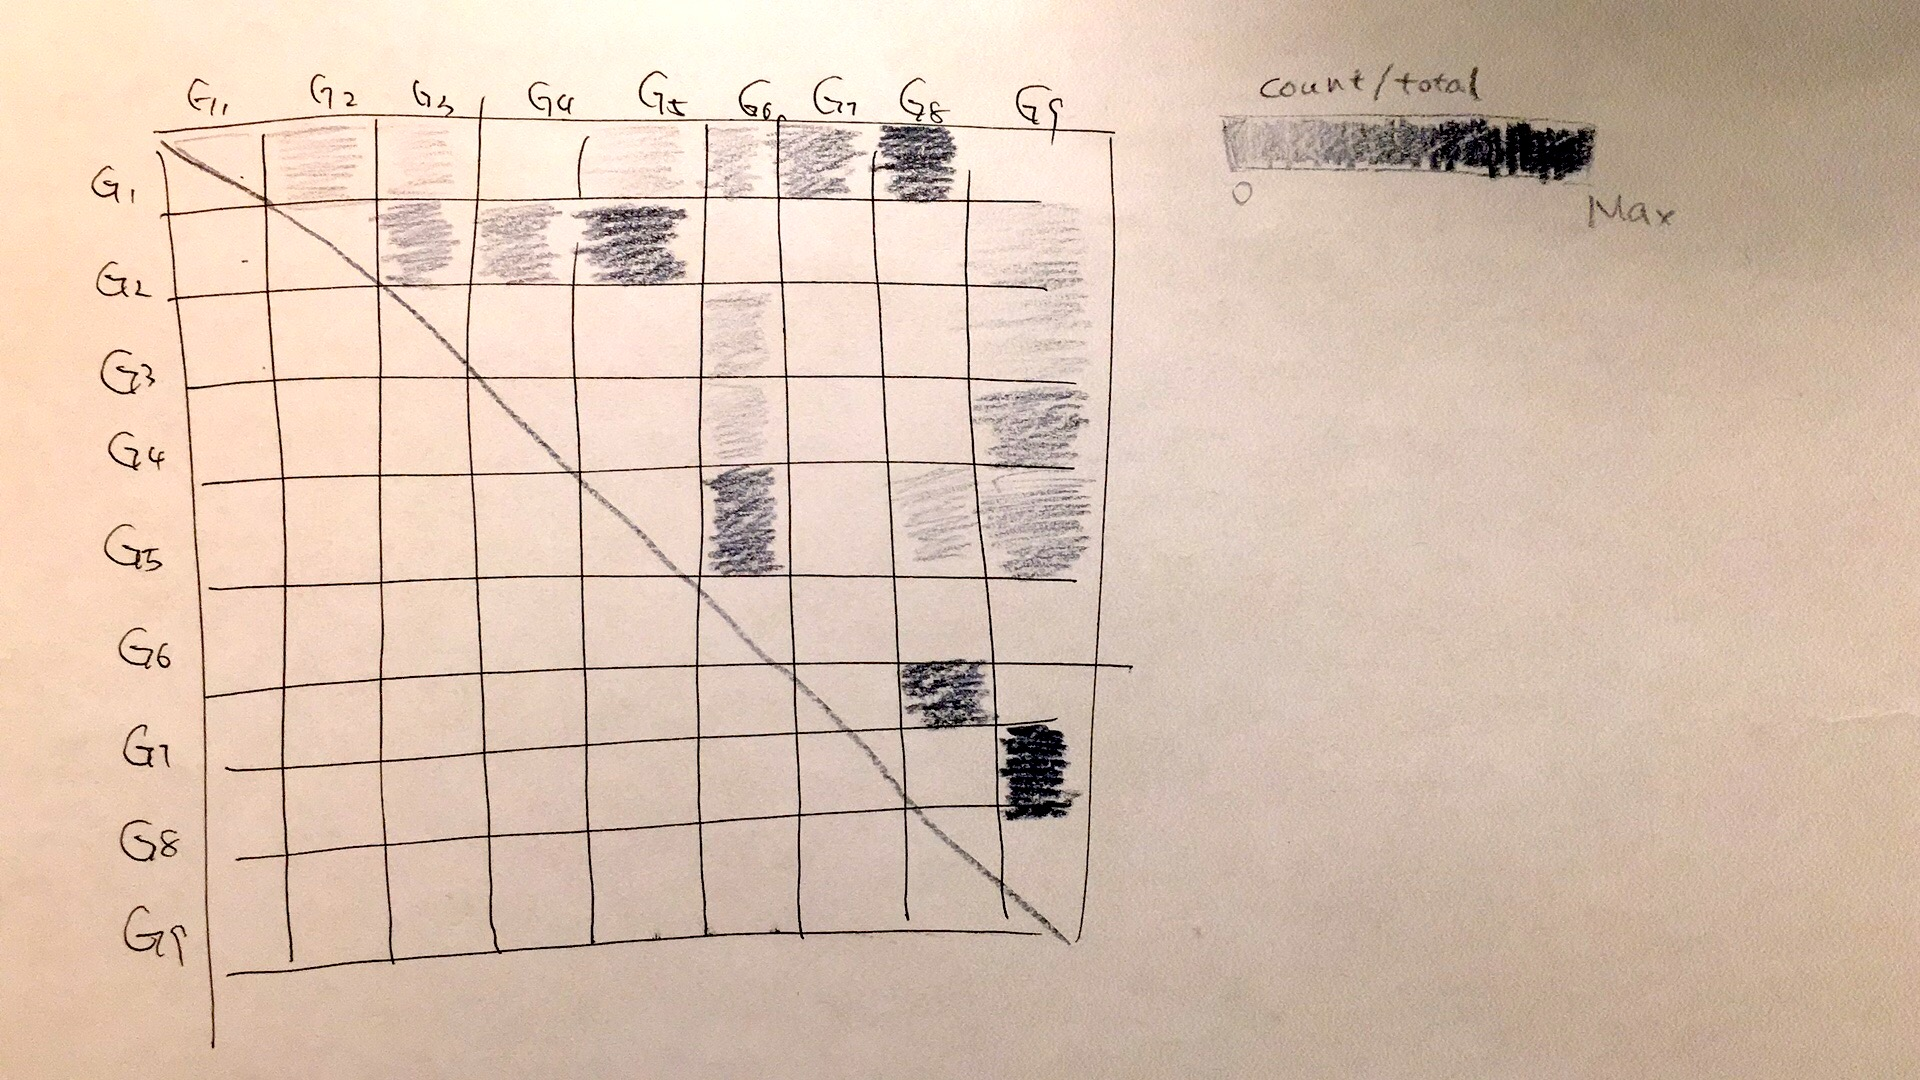

In [322]:
from IPython.display import Image
Image(filename='./sketches/3.jpg',width=1000)

### EDA!!

For additional visualization to solve several questions that we proposed above, we only look at TMDb data. It takes relatively longer for us to download data from IMBd and the metadata is more messay that needs further cleaning. We leave the discussion of merging these two datasets in the next section.

**For now, we base our analysis only on TMDb dataset.!**

### **Download data!** We have already downloaded the data. The codes are running on another notebook.

In [ ]:
#TMDb
dir_name = os.path.expanduser('~/tmdb_movie/')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

latest_movie_text = tmdb_get_latest_movie()
latest_movie_tmdb_id = tmdb_get_tmdb_id(latest_movie_text)
time.sleep(0.26)

for current_id in range(445681, int(latest_movie_tmdb_id)+1):
    current_id_string = str(current_id).zfill(6)
    current_movie_text = tmdb_get_movie_by_tmdb_id(current_id_string)
    time.sleep(0.26)
    if tmdb_exist(current_movie_text):
        file_name = "tmdb_"+current_id_string+".txt"
        full_path = os.path.join(dir_name, file_name)
        with open(full_path, "wb") as myfile:
            pickle.dump(current_movie_text, myfile)
    print "\rdownloaded movie id {}/{}, movie exist? {}".format(current_id_string, 
                                                                latest_movie_tmdb_id,
                                                               tmdb_exist(current_movie_text)),
    sys.stdout.flush()

In [ ]:
# IMDb 

ia = IMDb()

# get all movie file names in the folder
dir_path = expanduser("~/tmdb_movie/")
movie_file_list = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

# for each movie file
for tmdb_id in range(9473, 450000):
    # get tmdb file name
    tmdb_file_name = "tmdb_" + str(tmdb_id).zfill(6) + ".txt"
    # if file does not exit, continue
    if not os.path.exists(join(dir_path, tmdb_file_name)):
        continue
    else:
        # open file
        with open(join(dir_path, tmdb_file_name), "rb") as myfile:
            # read movie text
            movie_text = pickle.load(myfile)
            # get imdb id
            imdb_id = tmdb_get_imdb_id(movie_text)
            # download movie text from IMDb
            try: 
                current_movie = ia.get_movie(imdb_id)
            except:
                current_movie = []
            if len(current_movie) > 0: # if movie found by id
                file_name = "imdb_" + imdb_id + ".txt"
                with open(join(expanduser("~/imdb_movie/"), file_name), "wb") as myfile:
                    pickle.dump(current_movie, myfile)
        print "\rdownloaded movie (tmdb id:{}, imdb id:{})".format(tmdb_id, imdb_id),
        sys.stdout.flush()

### **Create dataframe for TMDb data**

In [51]:
#get file list
dir_path = expanduser("./data/tmdb_movie/")
movie_file_list = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

# read file into a list
data = []
for movie_file in movie_file_list:
    with open(join(dir_path, movie_file), "rb") as myfile:
        movie_text = json.loads(pickle.load(myfile))
        data.append(movie_text)

In [274]:
#reformate data into a dataframe
tmdb_demo = pd.DataFrame(data)
tmdb_demo.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/z2QUexmccqrvw1kDMw3R8TxAh5E.jpg,{u'backdrop_path': u'/ibLeWo3X3dVo4rxvn4m3y90m...,0,"[{u'id': 18, u'name': u'Drama'}, {u'id': 80, u...",,2,tt0094675,fi,Ariel,...,1988-10-21,0,69.0,"[{u'iso_639_1': u'fi', u'name': u'suomi'}, {u'...",Released,,Ariel,False,6.8,33
1,False,/6YjUX87VtIEuDzanBE6obVxE9V3.jpg,{u'backdrop_path': u'/ibLeWo3X3dVo4rxvn4m3y90m...,0,"[{u'id': 18, u'name': u'Drama'}, {u'id': 35, u...",,3,tt0092149,fi,Varjoja paratiisissa,...,1986-10-16,0,76.0,"[{u'iso_639_1': u'en', u'name': u'English'}, {...",Released,,Shadows in Paradise,False,6.8,25
2,False,/3EqYpbGCE9S5GddU2K4cYzP5UmI.jpg,None,4000000,"[{u'id': 35, u'name': u'Comedy'}]",,5,tt0113101,en,Four Rooms,...,1995-12-25,4300000,98.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,False,6.4,388
3,False,/eXKgVIjLCFNpQkjVg1VpA8yM2GA.jpg,None,0,"[{u'id': 28, u'name': u'Action'}, {u'id': 53, ...",,6,tt0107286,en,Judgment Night,...,1993-10-15,12136938,110.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,False,6.6,61
4,False,/udvB86uyzJ6P9vmB83WfrCbnmnI.jpg,None,42000,"[{u'id': 99, u'name': u'Documentary'}]",http://www.lifeinloops.com,8,tt0825671,en,Life in Loops (A Megacities RMX),...,2006-01-01,0,80.0,"[{u'iso_639_1': u'en', u'name': u'English'}, {...",Released,A Megacities remix.,Life in Loops (A Megacities RMX),False,5.2,3


In [201]:
#all the attributes we have now
tmdb_demo.columns

Index([u'adult', u'backdrop_path', u'belongs_to_collection', u'budget',
       u'genres', u'homepage', u'id', u'imdb_id', u'original_language',
       u'original_title', u'overview', u'popularity', u'poster_path',
       u'production_companies', u'production_countries', u'release_date',
       u'revenue', u'runtime', u'spoken_languages', u'status', u'tagline',
       u'title', u'video', u'vote_average', u'vote_count'],
      dtype='object')

### **Observe problems**

In [220]:
tmdb_demo.sort_values('vote_average')['genres'][:2]

155595    [{u'id': 99, u'name': u'Documentary'}]
198244                                        []
Name: genres, dtype: object

**Problem**: Some movies have entitie of genres to be empty. We mannually assaign it to be an additional **'unknown'** genre.

In [269]:
tmdb_demo.sort_values('vote_average')['vote_average'].value_counts()[[0]]

0    185571
Name: vote_average, dtype: int64

In [270]:
tmdb_demo.sort_values('vote_count')['vote_count'].value_counts()[[0]]

0    184307
Name: vote_count, dtype: int64

In [271]:
tmdb_demo.sort_values('popularity')['popularity'].value_counts()[[0]]

0    13723
Name: popularity, dtype: int64

**Problem:** There are so many **zero ratings, zero counts and zero popularity**, which will very likely to drag down the average of each genres of movies!!! We decide, for EDA, discard these zeros and leave this problem to further discussion. We have to figure out whether it is a result of zero ratings/counts/popularity for real, or a result of empty observation, say missing value.  

### **Data Cleaning**

In [276]:
#data cleaning
tmdb_demo['genres'] = tmdb_demo['genres'].apply(lambda x: [{'name': 'unknown'}] if x == [] else x)
print tmdb_demo.shape
tmdb_demo.head(3)

(311191, 25)


,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/z2QUexmccqrvw1kDMw3R8TxAh5E.jpg,{u'backdrop_path': u'/ibLeWo3X3dVo4rxvn4m3y90m...,0,"[{u'id': 18, u'name': u'Drama'}, {u'id': 80, u...",,2,tt0094675,fi,Ariel,...,1988-10-21,0,69.0,"[{u'iso_639_1': u'fi', u'name': u'suomi'}, {u'...",Released,,Ariel,False,6.8,33
1,False,/6YjUX87VtIEuDzanBE6obVxE9V3.jpg,{u'backdrop_path': u'/ibLeWo3X3dVo4rxvn4m3y90m...,0,"[{u'id': 18, u'name': u'Drama'}, {u'id': 35, u...",,3,tt0092149,fi,Varjoja paratiisissa,...,1986-10-16,0,76.0,"[{u'iso_639_1': u'en', u'name': u'English'}, {...",Released,,Shadows in Paradise,False,6.8,25
2,False,/3EqYpbGCE9S5GddU2K4cYzP5UmI.jpg,None,4000000,"[{u'id': 35, u'name': u'Comedy'}]",,5,tt0113101,en,Four Rooms,...,1995-12-25,4300000,98.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,False,6.4,388


### Visualization!! 

#### 1.What is the distribution of the genres. Do we have more romance movies？

Counter({'unknown': 121100, u'Drama': 69361, u'Comedy': 48764, u'Documentary': 28194, u'Action': 19495, u'Romance': 18887, u'Thriller': 18231, u'Horror': 15259, u'Music': 13507, u'Animation': 12840, u'Crime': 12405, u'Family': 10914, u'Adventure': 9740, u'Science Fiction': 7729, u'Fantasy': 6561, u'Foreign': 6272, u'Mystery': 6227, u'History': 4382, u'Western': 4066, u'War': 3907, u'TV Movie': 3622})


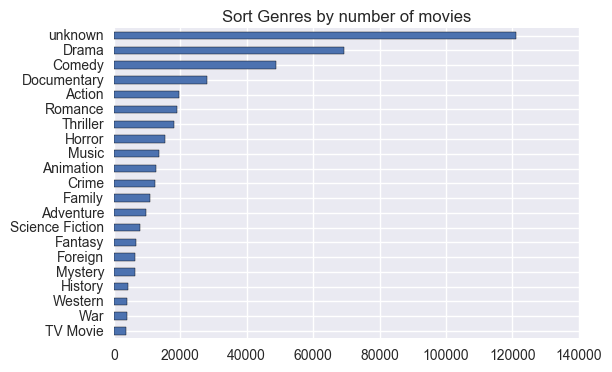

In [298]:
print Counter(genre_collapse_list)

df = pd.DataFrame.from_dict(Counter(genre_collapse_list), orient='index')
df.sort_values(0, ascending = True).plot(kind='barh', legend = False)
plt.title('Sort Genres by number of movies')
plt.show()

**Observation: Besides unknown type of movies, hah, Drama is the most frequent genre in the dataset, approximately 67000 movies are tagged by this genre. Comedy is following with 47000. These are our favorite genres, yeah! Well, people hate war and history may be a bit boring? Great~**

#### 2.Now, we are interested in visualizing the correlation between genres and attributes like **ratings, number of ratings, popularity, etc.** We think it is simple and helpful to compare the average attributes among all the genres and see whether they vary a lot or not.

In [280]:
def attr_vs_genres(attr_name):
    data = tmdb_demo[[attr_name,'genres']]
    data = data[data[attr_name] != 0]
    data.index = range(data.shape[0])
    
    result = {}
    for i in range(data.shape[0]):
        genre = data.loc[i,'genres']
        attr_value = data.loc[i,attr_name]
        for g in genre:
            if g['name'] in result:
                result[g['name']][0] += attr_value
                result[g['name']][1] += 1
            else:
                result[g['name']] = [0,0]
    
    return result

#### Average ratings VS genres!

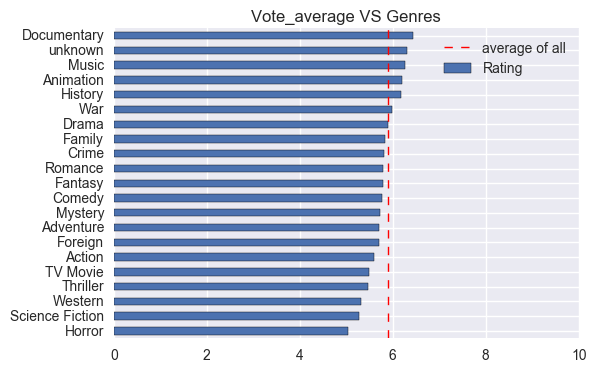

In [283]:
rating_dict = attr_vs_genres('vote_average')
rating_dict = {k:v[0]/v[1] for k,v in rating_dict.iteritems()}
df = pd.DataFrame.from_dict(rating_dict,orient='index')
df.sort_values(0,ascending = True).plot(kind='barh')
plt.xlim(0,10)
plt.title('Vote_average VS Genres')
plt.axvline(x = 6, linestyle = "--", color = "r", linewidth = 1)
plt.legend(['top 5','Rating'])
plt.show()

**Observations: The average ratings do not differ greatly, although we see a relative low average ratings for horror and thriller movies, em, scary, and higher ratings for Documentary, Music and Animation.**

#### Average popularity VS genres!

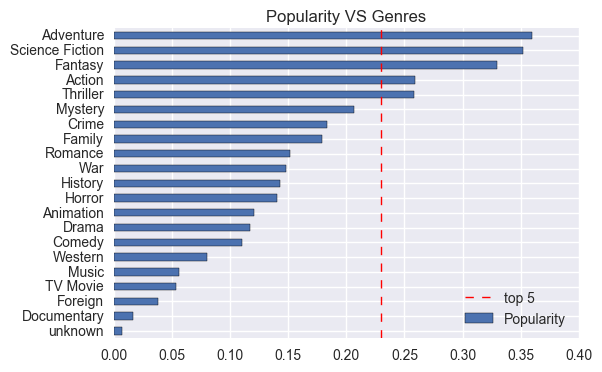

In [311]:
pop_dict = attr_vs_genres('popularity')
pop_dict = {k:v[0]/v[1] for k,v in pop_dict.iteritems()}
df = pd.DataFrame.from_dict(pop_dict,orient='index')
df.sort_values(0,ascending = True).plot(kind='barh')
# plt.xlim(0,10)
plt.title('Popularity VS Genres')
plt.axvline(x = 0.23, linestyle = "--", color = "r", linewidth = 1)
plt.legend(['top 5','Popularity'], loc = 4)
plt.show()

**Observations: Top 5 popular genres: Adventure, Science fiction, Fantasy, Actiona and Thirller. **

#### Average Vote Counts VS genres!

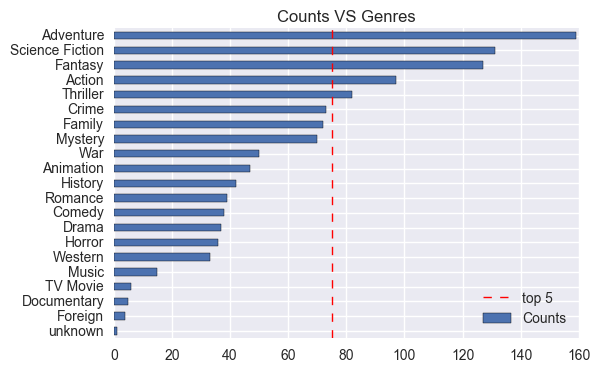

In [314]:
count_dict = attr_vs_genres('vote_count')
count_dict = {k:v[0]/v[1] for k,v in count_dict.iteritems()}
df = pd.DataFrame.from_dict(count_dict,orient='index')
df.sort_values(0,ascending = True).plot(kind='barh')
plt.title('Counts VS Genres')
plt.axvline(x = 75, linestyle = "--", color = "r", linewidth = 1)
plt.legend(['top 5','Counts'], loc = 4)
plt.show()

**Observations: Top 5 genres with most average number of ratings: Adventure, Science fiction, Fantasy, Actiona and Thirller. Wow! The same as above!**

## 7.Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them

###  Merge IMDb and TMDb

Although IMDb and TMDb share joint movie information and supplement each other, there are still differences that will cause confoundedness in the future analyses and predictions.

Genres from IMDb:  [u'Adventure', u'Family', u'Fantasy']
Genres from TMDb:  [{u'id': 12, u'name': u'Adventure'}, {u'id': 28, u'name': u'Action'}, {u'id': 14, u'name': u'Fantasy'}]

To take full advantage of the data we have now from TMDb and IMDb, we have to merge the two datasets. However, we will face some problems:
1. There are ratings attribute from both datasets and they are not always the same. We decide to take the mean if they do not differ much, we consider remove it if the distance is more than, say 2.  
 
2. As for the titles, we considered two ways:
    1. Use english titles
    2. Use the local language for a movie's title as where it was produced    
    **We finally dicide to go with the 1st option since languages are not comparable among countries as they have different grammar systems.**

3. The genres from both datasets are different: From our favorite movie, we have genres as **Adventure, Family and Fantasy** from IMDb while we have **Adventure, Action adn Fantasy** from TMDb. To fix the categorical inconsistencies from the two datasets, we decide to define a movie’s genres to be the joint tags shared by the two datasets. If no shared genre is found, we may either remove it or to come up with other options, e.g. try to see whether that have shared genre is related pairs (romand is highly related to drama).  
 
4. Intuitively, the **main cast** is highly correlated with the genres. We can foresee the difficulty in using the cast for prediction because the names will be treated as factors in modeling. Including even one leading character for each movie will cause incredibly long categorical variable for our datasets. By common sense, we prefer to treat the director name as a categorical variable since it can be more correlated with the genres and may have fewer unique directors. 

    Nevertheless, we still want to incorporate cast information in the prediction, which we believe to be important. We consider to transfer the attributes that having performers’ names into numerical variables, such as **facebook likes, twitter followers, average ages etc, and multiple dummies variables, such as whether the main cast won academy awards**. 



**IMDb select attributes**

We have got plenty of metadata from IMDd about a good number of crew name list. However, some is not quite related with genres like visual effects while some may be good indicators of genre like directors. We will keep several and then further decide how to efficiently turn them into attributs. Dummifying all the name is not doable, since we may forsee the problem coming with high sparcity. A good way is to use what we suggested int the above 4th question.

In [15]:
favorite_movie_imdb.keys()

[u'music department',
 'sound crew',
 'camera and electrical department',
 u'distributors',
 'rating',
 'runtimes',
 'costume designer',
 'make up',
 'year',
 'production design',
 'miscellaneous crew',
 'color info',
 u'casting department',
 'languages',
 'votes',
 'producer',
 'title',
 'mpaa',
 'assistant director',
 'writer',
 'casting director',
 'visual effects',
 'production manager',
 'set decoration',
 'editor',
 'certificates',
 u'costume department',
 'country codes',
 'language codes',
 'cover url',
 u'special effects department',
 'special effects companies',
 'sound mix',
 u'location management',
 'genres',
 'director',
 'stunt performer',
 'miscellaneous companies',
 'cinematographer',
 'art direction',
 'akas',
 'aspect ratio',
 u'production companies',
 'kind',
 u'art department',
 'countries',
 u'transportation department',
 'plot outline',
 'plot',
 'cast',
 u'animation department',
 'original music',
 u'editorial department',
 'canonical title',
 'long imdb title',


**Get person Info**

We get either acquire personal information from IMDb/TMDb or external resources like wiki, facebook, twitter and instagram.

In [316]:
print str(favorite_movie_imdb['director'])
person = ia.get_person('0946734')
print person.keys()

[<Person id:0946734[http] name:_Yates, David_>]
['name', u'producer', 'in development', u'self', u'writer', 'mini biography', u'actor', u'director', 'birth notes', u'thanks', 'headshot', 'imdbIndex', 'birth date', 'canonical name', 'long imdb name', 'long imdb canonical name', 'full-size headshot']


## 8.Others

**IMDb Load data**

The result retured from IMDb is not of traditional dictionary structure. We have to manually transform it into something we can work on.

In [ ]:
#convert imdb movie object to dictionary, every value is string based
def imdb_to_dict(movie):
    
    new_dict = {}
    new_dict['imdb_id'] = movie.getID()
    
    for ele in attr_keep_imdb:
        
        #check type list and convert every element to str
        if type(movie[ele]) == list:
            value = [str(i) for i in movie[ele]]
            new_dict[ele] = value
            
        new_dict[ele] = str(movie[ele])
    
    df = pd.DataFrame([new_dict])
    return df

In [264]:
def load_data(imdb = False, tmdb = False):
    if tmdb:
        dir_path = expanduser("./data/tmdb_movie/")
        movie_file_list = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

        # read file into a list
        data = []
        for movie_file in movie_file_list:
            with open(join(dir_path, movie_file), "rb") as myfile:
                movie_text = json.loads(pickle.load(myfile))
                data.append(movie_text)
    if imdb:
        dir_path = expanduser("./data/imdb_movie/")
        movie_file_list = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

        # read file into a list
        data = []
        for movie_file in movie_file_list[:2]:
            with open(join(dir_path, movie_file), "rb") as myfile:
                movie_text = imdb_to_dict(pickle.load(myfile))
                data.append(movie_text)